In [41]:
import numpy as np
import pandas as pd
from random import randint

import os
from itertools import zip_longest
from time import time

from sklearn.metrics import classification_report
import umap
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from sklearn.metrics import confusion_matrix


from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing, metrics, model_selection, neural_network, linear_model, ensemble
import matplotlib.pyplot as plt
from scipy import stats


In [3]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [4]:
if os.path.exists('data'):
    train_df = pd.read_csv(os.path.join(os.path.abspath('.'), 
                                        "data", 
                                        "train.csv"))
    test_df = pd.read_csv(os.path.join(os.path.abspath('.'), 
                                        "data", 
                                        "test.csv"))

In [5]:
print(f"Shape of the train_df: {train_df.shape} \nShape of the test_df: {test_df.shape}")

Shape of the train_df: (1760, 172) 
Shape of the test_df: (16626, 172)


In [6]:
#Capturing the columns names
features = list(train_df.columns)

### We note that labels "id", "genus" and "species" are present

In [7]:
features.remove("id")
features.remove("genus")
features.remove("species")

In [8]:
train_df.species.unique()

array(['flammea', 'palustris', 'schoenobaenus', 'scirpaceus', 'caudatus',
       'arvensis', 'pratensis', 'trivialis', 'apus', 'canadensis',
       'alpina', 'europaeus', 'carduelis', 'familiaris', 'chloris',
       'ridibundus', 'monedula', 'livia', 'oenas', 'palumbus', 'corax',
       'corone', 'frugilegus', 'canorus', 'caeruleus', 'urbicum', 'major',
       'martius', 'calandra', 'citrinella', 'schoeniclus', 'rubecula',
       'coelebs', 'atra', 'gallinago', 'chloropus', 'glandarius',
       'stellata', 'ostralegus', 'rustica', 'torquilla', 'lagopus',
       'argentatus', 'cannabina', 'fluviatilis', 'curvirostra',
       'megarhynchos', 'apiaster', 'aguimp', 'flava', 'striata',
       'oriolus', 'domesticus', 'montanus', 'perdix', 'ater', 'apivorus',
       'colchicus', 'phoenicurus', 'collybita', 'sibilatrix', 'trochilus',
       'pica', 'viridis', 'apricaria', 'squatarola', 'modularis',
       'pyrrhula', 'regulus', 'europaea', 'decaocto', 'turtur', 'aluco',
       'vulgaris', 'at

'There are aparently 85 species in the training dataset'

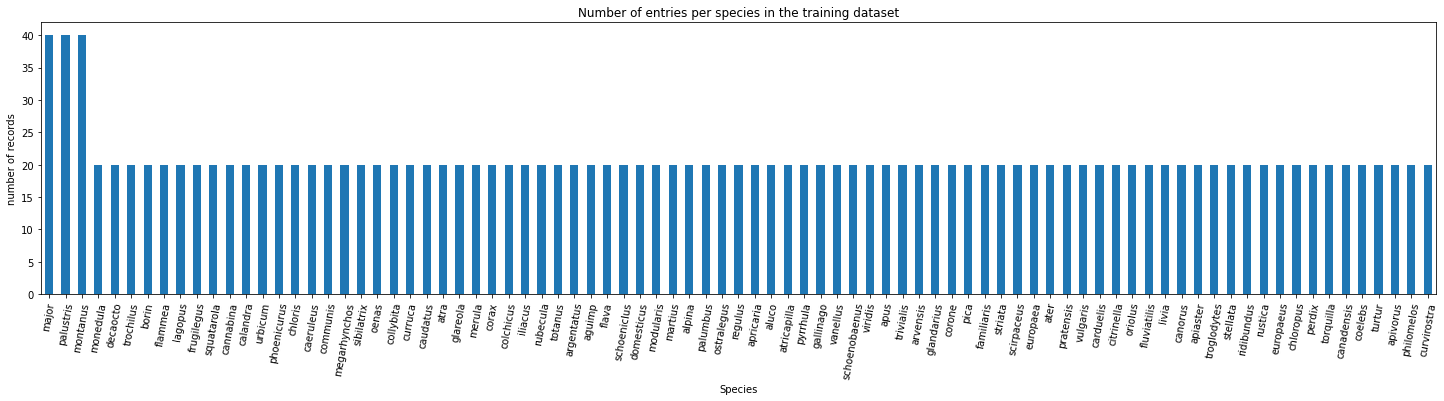

In [9]:
fig, ax = plt.subplots(figsize=(25,5))
train_df['species'].value_counts().plot.bar(ax=ax)
plt.title("Number of entries per species in the training dataset" )
plt.xlabel('Species')
plt.xticks(rotation=80)
plt.ylabel('number of records');
plt.show
f"There are aparently {len(train_df.species.unique())} species in the training dataset"

##  It looks like there are more than 20 records for species
but closer inpection shows that in fact there are 20 records per each. We must cont the full name for a specie, that is the genus + species

In [10]:
train_df['full_sp_name'] = train_df['genus'] + '_' + train_df['species']
test_df['full_sp_name'] = test_df['genus'] + '_' + test_df['species']

but in fact there are 88 species
and actually 20 records per specie


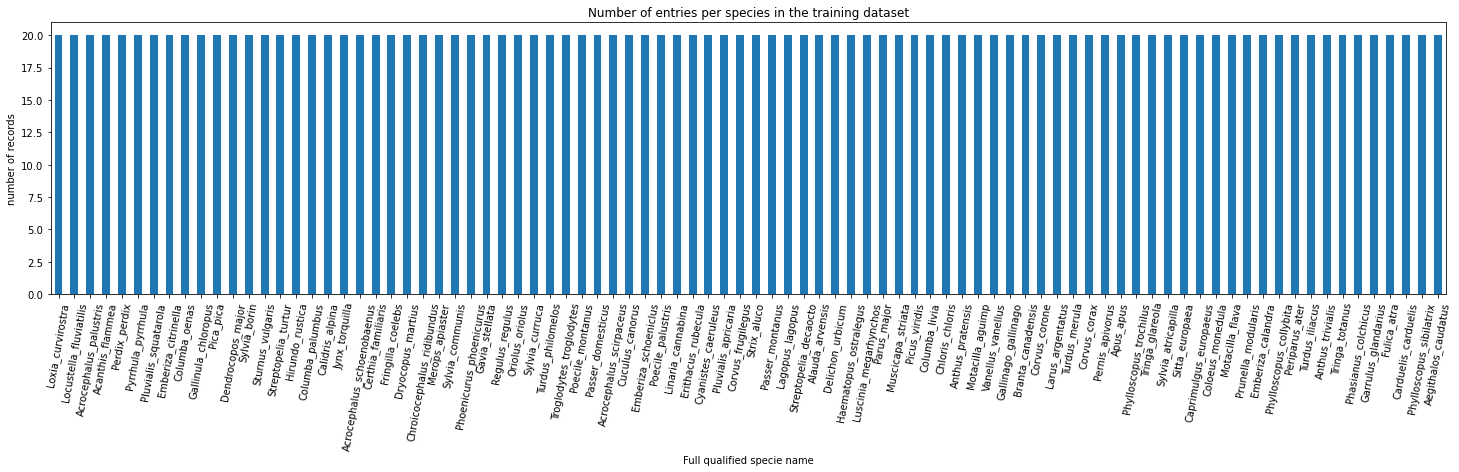

In [11]:
fig, ax = plt.subplots(figsize=(25,5))
train_df['full_sp_name'].value_counts().plot.bar(ax=ax)
plt.title("Number of entries per species in the training dataset" )
plt.xlabel('Full qualified specie name')
plt.xticks(rotation=80)
plt.ylabel('number of records');
plt.show
print(f"but in fact there are {len(train_df.full_sp_name.unique())} species\nand actually 20 records per specie" )

## Exlporing the test df

but in fact there are 87 and diverse number of records per specie


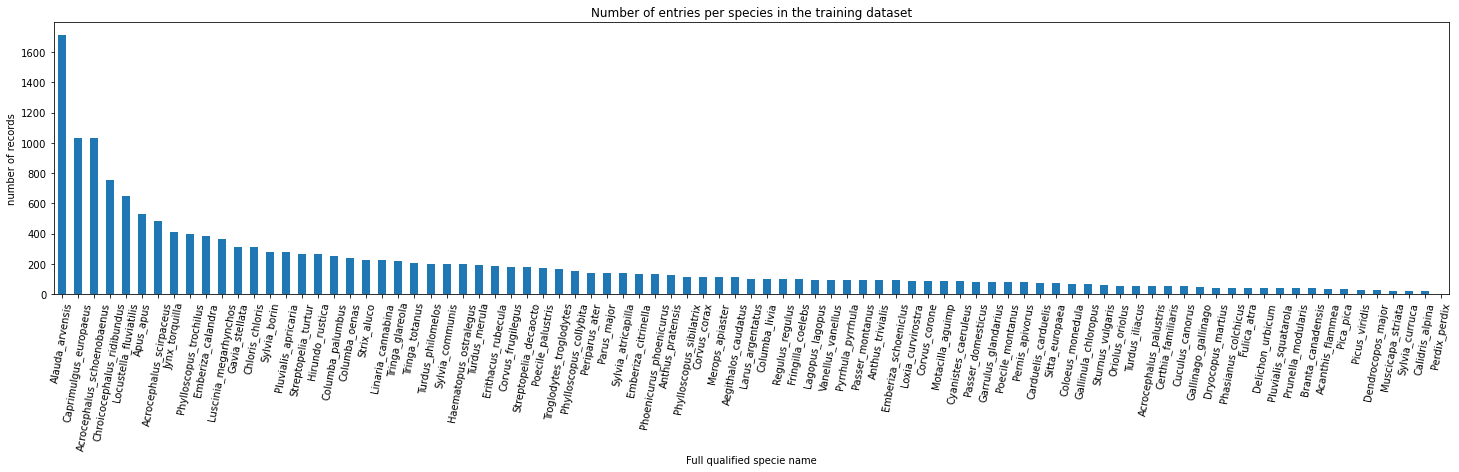

In [12]:
fig, ax = plt.subplots(figsize=(25,5))
test_df['full_sp_name'].value_counts().plot.bar(ax=ax)
plt.title("Number of entries per species in the training dataset" )
plt.xlabel('Full qualified specie name')
plt.xticks(rotation=80)
plt.ylabel('number of records');
plt.show
print(f"but in fact there are {len(test_df.full_sp_name.unique())} and diverse number of records per specie" )

## Scale/standarize dataset and encode the label

In [13]:
scaler = preprocessing.StandardScaler()# Declare an instance of the transformer/scaler
scaler.fit(train_df[features])# Compute the transformation

train_df[features] = pd.DataFrame(scaler.transform(train_df[features]), columns=features)# Transform (scale) the features on the train_df
test_df[features] = pd.DataFrame(scaler.transform(test_df[features]), columns=features)# Transform (scale) the features on the test_df

##  We take split half of the test dataframe for later validation

In [14]:
X_val, X_test, Y_val, Y_test = train_test_split(test_df[features], test_df['full_sp_name'], test_size=0.5, random_state=1000, stratify=test_df['full_sp_name'])

###  We will use now as:
   1. Validation  dataset-> `x_val`, `y_val`: we will run the model and asses accuraca on the model training with this dataset.
   2. Test dataset -> `x_test`, `y_test`: The model will never see this dataset until the end to see how perfomr with unkonw data.
   3. And the training dataset remains is taking below from the original dataframe.

In [15]:
# Define the training dataset.
x_train = train_df[features].values

y_train_raw = train_df['full_sp_name'].values
le = preprocessing.LabelEncoder()# *** Help normalize labels (numeric or in this case strings) such that they contain only values between 0 and n_classes-1

y_train = le.fit_transform(y_train_raw)# Transform autput labels to numeric values.


# Define the test and validation datasets.

x_test = X_test.values
y_raw_test = Y_test.values

y_test = le.transform(y_raw_test)



x_val = X_val.values
y_val_test = Y_val.values

y_val = le.transform(y_val_test)

In [16]:
print(f"shape of train data: x_train = {x_train.shape}, y_train = {y_train.shape}\nshape of test data: x_test = {x_test.shape}, y_test = {y_test.shape}\nshape of val data: x_val = {x_val.shape}, y_val = {y_val.shape}")

shape of train data: x_train = (1760, 169), y_train = (1760,)
shape of test data: x_test = (8313, 169), y_test = (8313,)
shape of val data: x_val = (8313, 169), y_val = (8313,)


In [17]:
test_df.shape

(16626, 173)

## Use PCA to show the dataset in a reduced space dimension

Explained variance ratio:  [0.198 0.115 0.106 0.064 0.045 0.038 0.028 0.022 0.020 0.019 0.017 0.016
 0.015 0.014 0.014 0.012 0.011 0.010 0.010 0.009 0.009 0.008 0.008 0.008
 0.007 0.007 0.006 0.006 0.006 0.006 0.005 0.005 0.005 0.005 0.005 0.004
 0.004 0.004 0.004 0.004 0.004 0.003 0.003 0.003 0.003 0.003 0.003 0.003
 0.003 0.003 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000

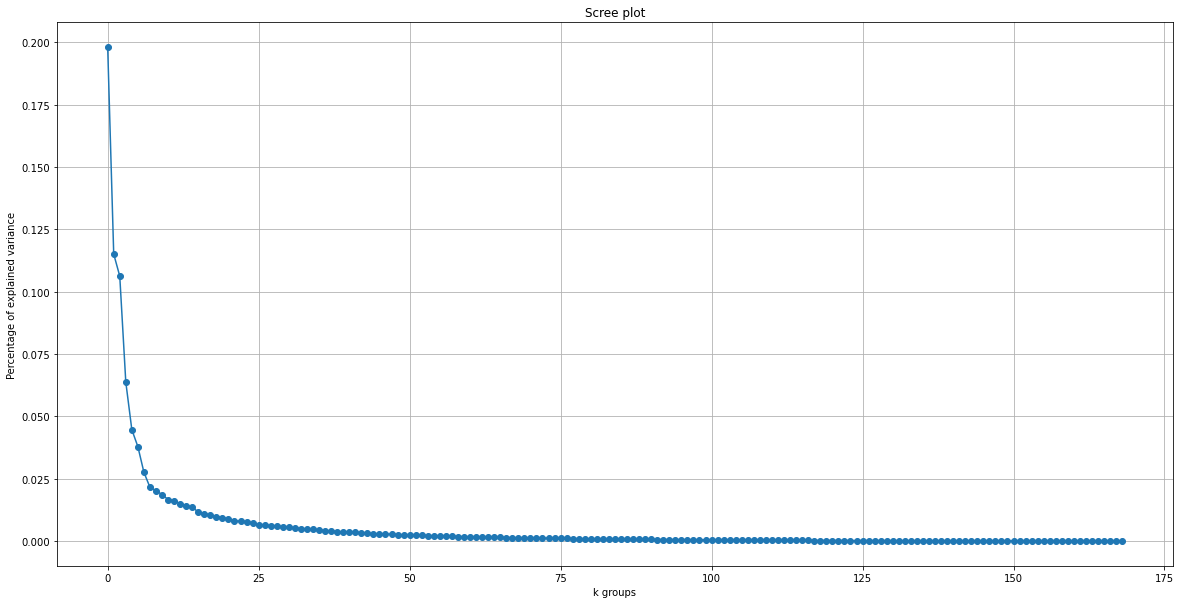

In [18]:
pca=PCA()
pca.fit(x_train)
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(pca.explained_variance_ratio_,'-o')
plt.title('Scree plot')
plt.ylabel('Percentage of explained variance')
plt.xlabel('k groups')
plt.grid()
print('Explained variance ratio: ' ,pca.explained_variance_ratio_)
plt.show()

## Embedding the firts two components of the PCA

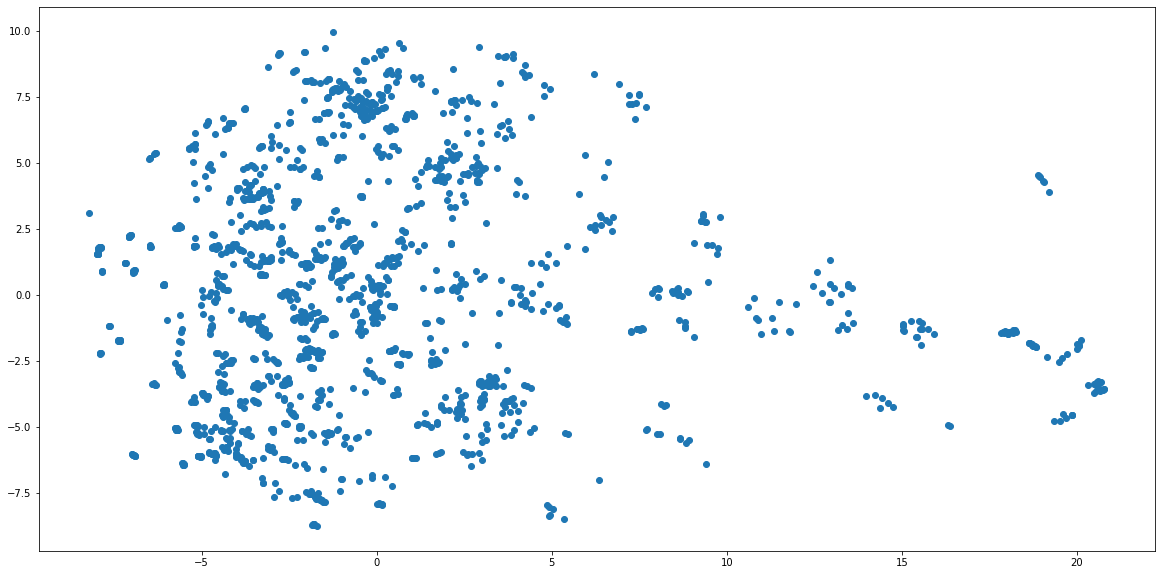

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
X_pca = pca.transform(x_train)
plt.plot(X_pca[:,0],X_pca[:,1],'o')

## Use umap (UMAP) to show the dataset in a reduced space dimension

#### Use a helper function to visualize various parameters

In [20]:
def draw_umap(n_neighbors=15, min_dist=0.1, 
              n_components=2, metric='euclidean', 
              title='', 
              plot_indx1 = 4, plot_indx2 = 4, plot_grid_size = 1, 
              font_s = 20,
              scat_s = 10):
    
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=9991
        
    )
    
    t0 = time()
    u = fit.fit_transform(X);
    t1 = time()

    if n_components == 1:
        ax = fig.add_subplot(plot_indx1, plot_indx2, plot_grid_size)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(plot_indx1, plot_indx2, plot_grid_size)
        ax.scatter(u[:,0], u[:,1], s=scat_s)
    if n_components == 3:
        ax = fig.add_subplot(plot_indx1, plot_indx2, plot_grid_size, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2],  s=scat_s)
    plt.title(title + f"\nelapsed time: {t1 - t0:.2f}", fontsize=font_s)


In [52]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100,max_depth=50)
forest.fit(x_train, y_train)
forest.score(x_val, y_val)
print("Accuracy on training set: {:.3f}".format(forest.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(x_val, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.990


In [62]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(x_train)
X_train_poly = poly.transform(x_train)
X_val_poly = poly.transform(x_val)

print("X_train.shape: {}".format(x_train.shape))
print("X_train_poly.shape: {}".format(X_train_poly.shape))

X_train.shape: (1760, 169)
X_train_poly.shape: (1760, 14534)


In [63]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(x_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(x_train, y_train)))
print("Test set score: {:.2f}".format(ridge.score(X_val, y_val)))

Training set score: 0.63
Test set score: 0.40


In [67]:
ridge = Ridge().fit(x_train, y_train)
print("Score without interactions: {:.3f}".format(
    ridge.score(x_val, y_val)))
ridge = Ridge().fit(X_train_poly, y_train)
print("Score with interactions: {:.3f}".format(ridge.score(X_val_poly, y_val)))

Score without interactions: 0.405
Score with interactions: 0.970


Score without interactions: 0.914


KeyboardInterrupt: 

In [68]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)
LinearSVC = LinearSVC(C=100)
LinearSVC.fit(x_train, y_train)
LinearSVC.score(X_val, y_val)
print("Training set score: {:.3f}".format(LinearSVC.score(x_train, y_train)))
print("Test set score: {:.3f}".format(LinearSVC.score(x_val, y_val)))

Training set score: 1.000
Test set score: 0.976


C:\Users\valer\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

logreg = LogisticRegression().fit(x_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(x_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_val, y_val)))

Training set score: 1.000
Test set score: 0.976


C:\Users\valer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
pred_logreg = logreg.predict(X_val)
confusion = confusion_matrix(y_val, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[ 18   0   0 ...   0   0   0]
 [  0  26   0 ...   0   0   0]
 [  0   0 503 ...   0   0   0]
 ...
 [  0   0   0 ...  91   0   0]
 [  0   0   0 ...   0  99   0]
 [  0   0   0 ...   0   0  47]]


In [71]:
logreg100 = LogisticRegression(C=100)
logreg100.fit(x_train, y_train)
print("Training set score: {:.3f}".format(logreg100.score(x_train, y_train)))
print("Test set score: {:.3f}".format(logreg100.score(X_val, y_val)))


Training set score: 1.000
Test set score: 0.979


C:\Users\valer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Exploring different neighbors and minimal distance (hyperparameter landscape)

#### Extractting 2 components

In [ ]:
# Run me only locally
components = 2
neigbords = [5, 10, 50, 100, 200]
distance = [0.1, 0.25, 0.5, 0.8, 0.99]

fig_Count = 0
nrows, ncols = len(neigbords), len(distance)

fig = plt.figure(figsize=(60, 60))

for indx1, n  in enumerate(neigbords, start=1):
    for indx2, d in enumerate(distance, start=1):
        fig_Count += 1
#         print(f"this is my neigb: {i} and this is my distance {j} and index1: {indx1} and index2: {indx2}")
        draw_umap(min_dist=d, 
                     n_neighbors=n,
                     n_components= components, 
                     title=f'min_dist = {d} and neigbords {n}',
                     plot_indx1 = nrows, plot_indx2 = ncols, plot_grid_size = fig_Count)

fig.tight_layout(pad=3)

## Use TSNE to show the dataset in a reduced space dimension

#### Use a helper function to visualize various parameters

In [ ]:
def draw_TSNE(n_perplex=125, 
              learn_rate=200, 
              early_exag=4.0,
              init='pca',
              n_itera=1000, 
              metric='euclidean', 
              verbo=100,
              title='', 
              plot_indx1 = 4, plot_indx2 = 4, plot_grid_size = 1, 
              font_s = 20,
              scat_s = 10):
    
    
    fit = TSNE(perplexity=n_perplex, 
               learning_rate=learn_rate, 
               early_exaggeration=early_exag,
               init=init,
               n_iter=n_itera, 
               random_state=9999991, 
               metric=metric, 
               verbose=0 )
    
    t0 = time()
    u = fit.fit_transform(X);
    t1 = time()

    ax = fig.add_subplot(plot_indx1, plot_indx2, plot_grid_size)
    ax.scatter(u[:,0], u[:,1], s=scat_s)
    
    plt.title(title + f"\nelapsed time: {t1 - t0:.2f}", fontsize=font_s)


In [ ]:
# Run me only locally

learning_rate=200
itera=500

perplexity=[10, 50, 100]
exagg=[1, 5.0, 10.0]



fig_Count = 0
nrows, ncols = len(perplexity), len(exagg)

fig = plt.figure(figsize=(40, 40))

for indx1, p  in enumerate(perplexity, start=1):
    for indx2, e in enumerate(exagg, start=1):
        fig_Count += 1
#         print(f"this is my neigb: {i} and this is my distance {j} and index1: {indx1} and index2: {indx2}")
        draw_TSNE(n_perplex=p, 
                  learn_rate=learning_rate, 
                  early_exag=e,
                  n_itera=itera,
                  title=f'Early_exaggeration = {e}\nperpelexity = {p}',
                  plot_indx1 = nrows, plot_indx2 = ncols, plot_grid_size = fig_Count,
                  font_s = 20, scat_s = 20)



## Exploring the numbers of clusters via K-means

In [ ]:
# Run me only locally

plt.figure(figsize=(20, 10))
scores=[]
clusters = 500


for itrial in range(2,clusters):
#     print('Number of clusters considered: ',itrial)
    clusterer = KMeans(n_clusters=itrial, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    score=silhouette_score(X,cluster_labels)
    scores.append(score)
    
plt.grid()
plt.plot(np.arange(len(scores))+2,np.array(scores),'-o')
plt.ylabel('Silohuette score');
plt.xlabel('number of clusters');

### Assesing Gaussian mixture for classification

In [ ]:
# # No need to run this code
# n_rows, n_cols = list(range(1, 5)), list(range(1, 5))
# start, end = 80, 96

# aic=[]
# bic=[]
# sil=[]

# scat_s = 20
# font_s = 20
# fig = plt.figure(figsize=(60, 60))

# for indx, i_comp in enumerate(range(start, end), start = 1):
#     ax = fig.add_subplot(len(n_rows), len(n_cols), indx)
    
#     clf =  GaussianMixture(n_components=i_comp, covariance_type='full')
    
    
# #     u = clf.fit_transform(X);
    
#     t0 = time()
#     clf.fit(X)
#     cluster_labels=clf.predict(X)
#     t1 = time()
    
#     ax.scatter(X[:,0], X[:,1], c = cluster_labels, s = scat_s)
#     plt.title(f"components: {i_comp}\nelapsed time :{t1 - t0:.2f}\nIC: {clf.aic(X):.2f}\nBIC: {clf.bic(X):.2f}\nSilhouette_score: {silhouette_score(X,cluster_labels):.2f}", fontsize = font_s)
    


In [ ]:
# plt.figure(figsize=(20, 10))
# scat_s = 20
# font_s = 20
# i_comp = 85
    
# clf =  GaussianMixture(n_components=i_comp, covariance_type='full')
    
    
# # u = clf.fit_transform(X);
    
# t0 = time()
# clf.fit(X)
# cluster_labels=clf.predict(X)
# t1 = time()


# plt.scatter(X[:,0], X[:,1], c = cluster_labels, s = scat_s)
# plt.title(f"components: {i_comp}\nelapsed time :{t1 - t0:.2f}\nIC: {clf.aic(X):.2f}\nBIC: {clf.bic(X):.2f}\nSilhouette_score: {silhouette_score(X,cluster_labels):.2f}", fontsize = font_s)

### Plot the Gaussian mixture performance

In [ ]:
plt.figure(figsize=(15, 15))
scat_s = 20
font_s = 20

n_components = np.arange(2, 100, 1)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='Bayesian information criterion (BIC)')
plt.plot(n_components, [m.aic(X) for m in models], label='Akaike information criterion (AIC)')
plt.legend(loc='best')
plt.xlabel('n_components', fontsize = font_s);



### Build and compare 3 models:
1. logisteic regression, 
2. Random Forest
3. Forward neural network


In [ ]:
scaler = preprocessing.StandardScaler()# Declare an instance of the transformer/scaler
scaler.fit(train_df[features])# Compute the transformation

train_df[features] = pd.DataFrame(scaler.transform(train_df[features]), columns=features)# Transform (scale) the features on the train_df
test_df[features] = pd.DataFrame(scaler.transform(test_df[features]), columns=features)# Transform (scale) the features on the test_df

X = train_df[features].values
y_raw = train_df['full_sp_name'].values

le = preprocessing.LabelEncoder()# *** Help normalize labels (numeric or in this case strings) such that they contain only values between 0 and n_classes-1

y = le.fit_transform(y_raw)# Transform autput labels to numeric values.

X_test = test_df[features].values
y_raw_test = test_df['full_sp_name'].values

y_test = le.transform(y_raw_test)



In [ ]:
# As we can see there are very noticeable clusters let's see if some model can learn to distinguish between the species

sss = model_selection.StratifiedShuffleSplit(n_splits=5,test_size=0.2)

log_reg_accs = []
log_reg_ap = []
log_reg_f1 = []
log_reg_preds = np.zeros((5,len(X_test)))

rand_forest_accs = []
rand_forest_ap = []
rand_forest_f1 = []
rand_forest_preds = np.zeros((5,len(X_test)))

nn_accs = []
nn_ap = []
nn_f1 = []
nn_preds = np.zeros((5,len(X_test)))

i = 0

for train_index, val_index in sss.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    log_reg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
    log_reg.fit(X_train, y_train)
    y_val_pred = log_reg.predict(X_val)
    log_reg_accs.append(metrics.accuracy_score(y_val_pred, y_val))
    log_reg_preds[i] = log_reg.predict(X_test)
    
    rand_forest = ensemble.RandomForestClassifier(n_estimators=100)
    rand_forest.fit(X_train, y_train)
    y_val_pred = rand_forest.predict(X_val)
    rand_forest_accs.append(metrics.accuracy_score(y_val_pred, y_val))
    rand_forest_preds[i] = rand_forest.predict(X_test)
    
    
    nn = neural_network.MLPClassifier(activation='relu',hidden_layer_sizes=[128,128])
    nn.fit(X_train, y_train)
    y_val_pred = nn.predict(X_val)
    nn_accs.append(metrics.accuracy_score(y_val_pred, y_val))
    nn_preds[i] = nn.predict(X_test)
    
    i += 1
    
print("Accuracy of Logistic Regression on validation set: ", np.mean(log_reg_accs))
print("Accuracy of Random Forest on validation set: ", np.mean(rand_forest_accs))
print("Accuracy of Feed Forward Neural Network on validation set: ", np.mean(nn_accs))

# Building a neural network with tensor flow

In [ ]:
for i in range(5, 20):
    print(2**i)

In [ ]:
my_bird_song_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2048, activation='relu', name="layer1", input_shape=(169,)),
#     tf.keras.layers.Dense(2048, activation='relu', name="layer3"),
#     tf.keras.layers.Dense(4096, activation='relu', name="layer4"),
#     tf.keras.layers.Dense(1024, activation='relu', name="layer5"),
#     tf.keras.layers.Dense(512, activation='relu', name="layer6"),
#     tf.keras.layers.Dense(256, activation='relu', name="layer7"),
    tf.keras.layers.Dense(88, activation='softmax', name="layer8")
    ])

my_bird_song_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
my_bird_song_model.summary()

### Model training

In [ ]:
save_path = 'save/nn_model_bird_class_{epoch}.ckpt'
save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, save_weights_only=True)

hist = my_bird_song_model.fit(x_train, y_train,
                              epochs=20, batch_size=150, 
                              validation_data=(x_val, y_val),#this has to be a tupple () not a list [] 
                              callbacks=[save_callback])

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].plot(hist.epoch, hist.history['val_loss'])
axs[0].legend(('training loss', 'validation loss'), loc='upper right')
axs[1].plot(hist.epoch, hist.history['accuracy'])
axs[1].plot(hist.epoch, hist.history['val_accuracy'])

axs[1].legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

In [ ]:
my_classes_dic = {}
for n, i in enumerate(le.classes_, start = 0):
    print(n, i )


## Pick a random entry from the unseen test dataset and make prediction

In [ ]:
print(f"shape of train data: x_train = {x_train.shape}, y_train = {y_train.shape}\nshape of test data: x_test = {x_test.shape}, y_test = {y_test.shape}\nshape of val data: x_val = {x_val.shape}, y_val = {y_val.shape}")

In [ ]:
my_test_value = randint(0, 8313)
print(f"The random entry is {my_test_value}\nand correspond to {le.inverse_transform([y_test[my_test_value]])[0]}")

In [ ]:
my_prediction = my_bird_song_model.predict(x_test[[my_test_value], :])

May be define a function that return the 3 hits with the highest probabilities?....

In [ ]:
my_prediction

In [ ]:
for n, i in enumerate(my_prediction[0], start=0):
    print(n, round(i, 3))